In [1]:
import sys
import os

# 获取当前notebook文件所在文件夹的父文件夹路径
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# 将父文件夹路径添加到sys.path中
sys.path.append(parent_dir)
import numpy as np
import torch
from utility import predict_func_2input_2out, load_best_model, sample_data, load_features_and_targets
from model_train.smalltransformer_w_sigma import SmallTransformer
from linear_process import preprocess_pro
from utility import cal_flux, predict_spectra
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from sklearn.cluster import KMeans

In [2]:
# Model
batch_size = 1
model = SmallTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, '/kaggle/best_model_STws_v3.5.pth')

Best model loaded.


In [44]:
full_predictions_spectra, full_whitelight_s_train, full_light_alpha_train, full_targets_normalized, target_min, target_max = load_features_and_targets(
)

In [4]:
sampled_indices = sample_data(full_targets_normalized)
len(sampled_indices)

c:\veighna_studio\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


640

In [5]:
mask = np.ones(full_predictions_spectra.shape[0], dtype=bool)
mask[sampled_indices] = False
predictions_spectra_test = full_predictions_spectra[mask]
min_values = predictions_spectra_test.min(axis=(1, 2), keepdims=True)
max_values = predictions_spectra_test.max(axis=(1, 2), keepdims=True)
normalized_spectra = (predictions_spectra_test - min_values) / (max_values -
                                                                min_values)
data_test_reshaped = torch.tensor(normalized_spectra).float()

In [6]:
predictions_spectra_test.shape

(340, 187, 283)

In [7]:
whitelight_s_test = full_whitelight_s_train[mask]
light_alpha_test = full_light_alpha_train[mask]
whitelight_s_train_expanded = np.expand_dims(full_whitelight_s_train[mask] *
                                             100,
                                             axis=1)
combined_array = np.concatenate(
    (light_alpha_test, whitelight_s_train_expanded), axis=1)
light_alpha_test = torch.tensor(combined_array).float()

In [48]:
mean_predictions, sigma_predictions = predict_func_2input_2out(
    model, data_test_reshaped, light_alpha_test, batch_size=1)
mean_predictions = mean_predictions * (target_max - target_min) + target_min
mean_predictions = mean_predictions.numpy()
sigma_predictions = sigma_predictions * (target_max - target_min)
sigma_predictions = sigma_predictions.numpy()

In [49]:
all_predictions = mean_predictions

In [50]:
all_predictions.min(), all_predictions.max()

(0.90812504, 1.1733565)

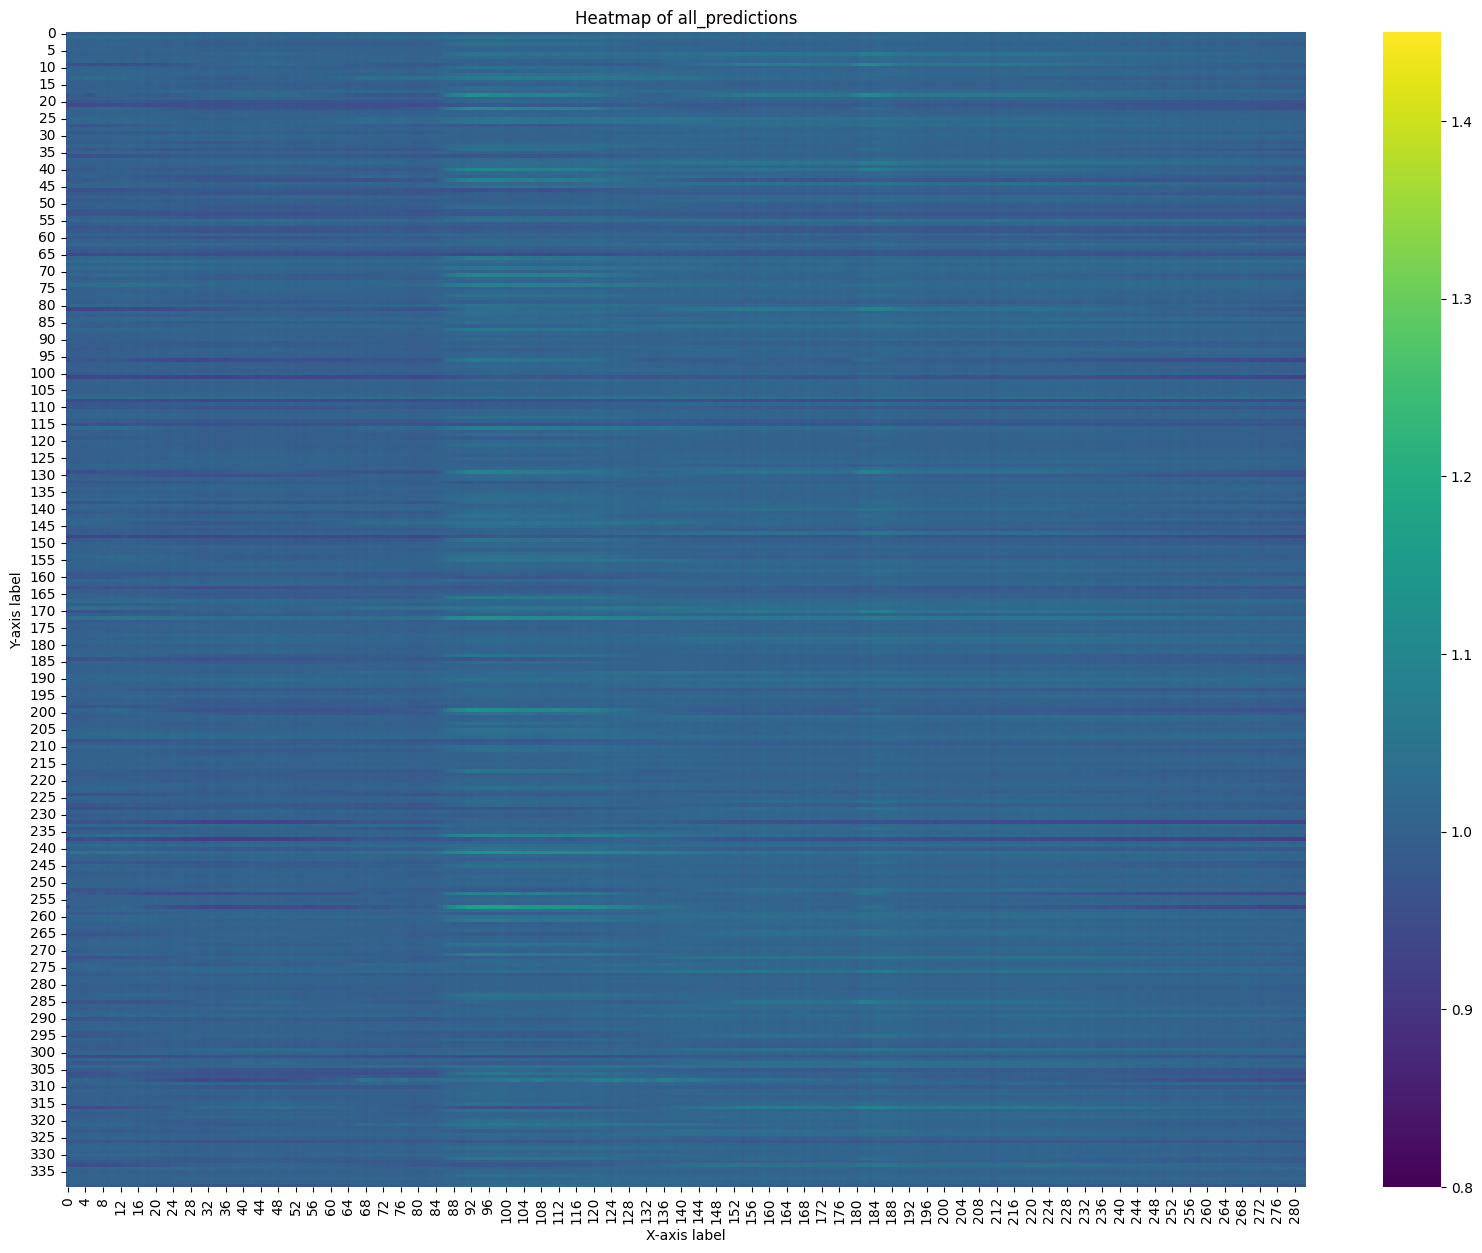

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(all_predictions,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of all_predictions")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [51]:
from utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv('input/ariel-data-challenge-2024/wavelengths.csv')
train_adc_info = pd.read_csv(
    'input/ariel-data-challenge-2024/train_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv('input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')

In [52]:
targets = full_targets_normalized * (target_max - target_min) + target_min
reviewtarget = targets[mask]

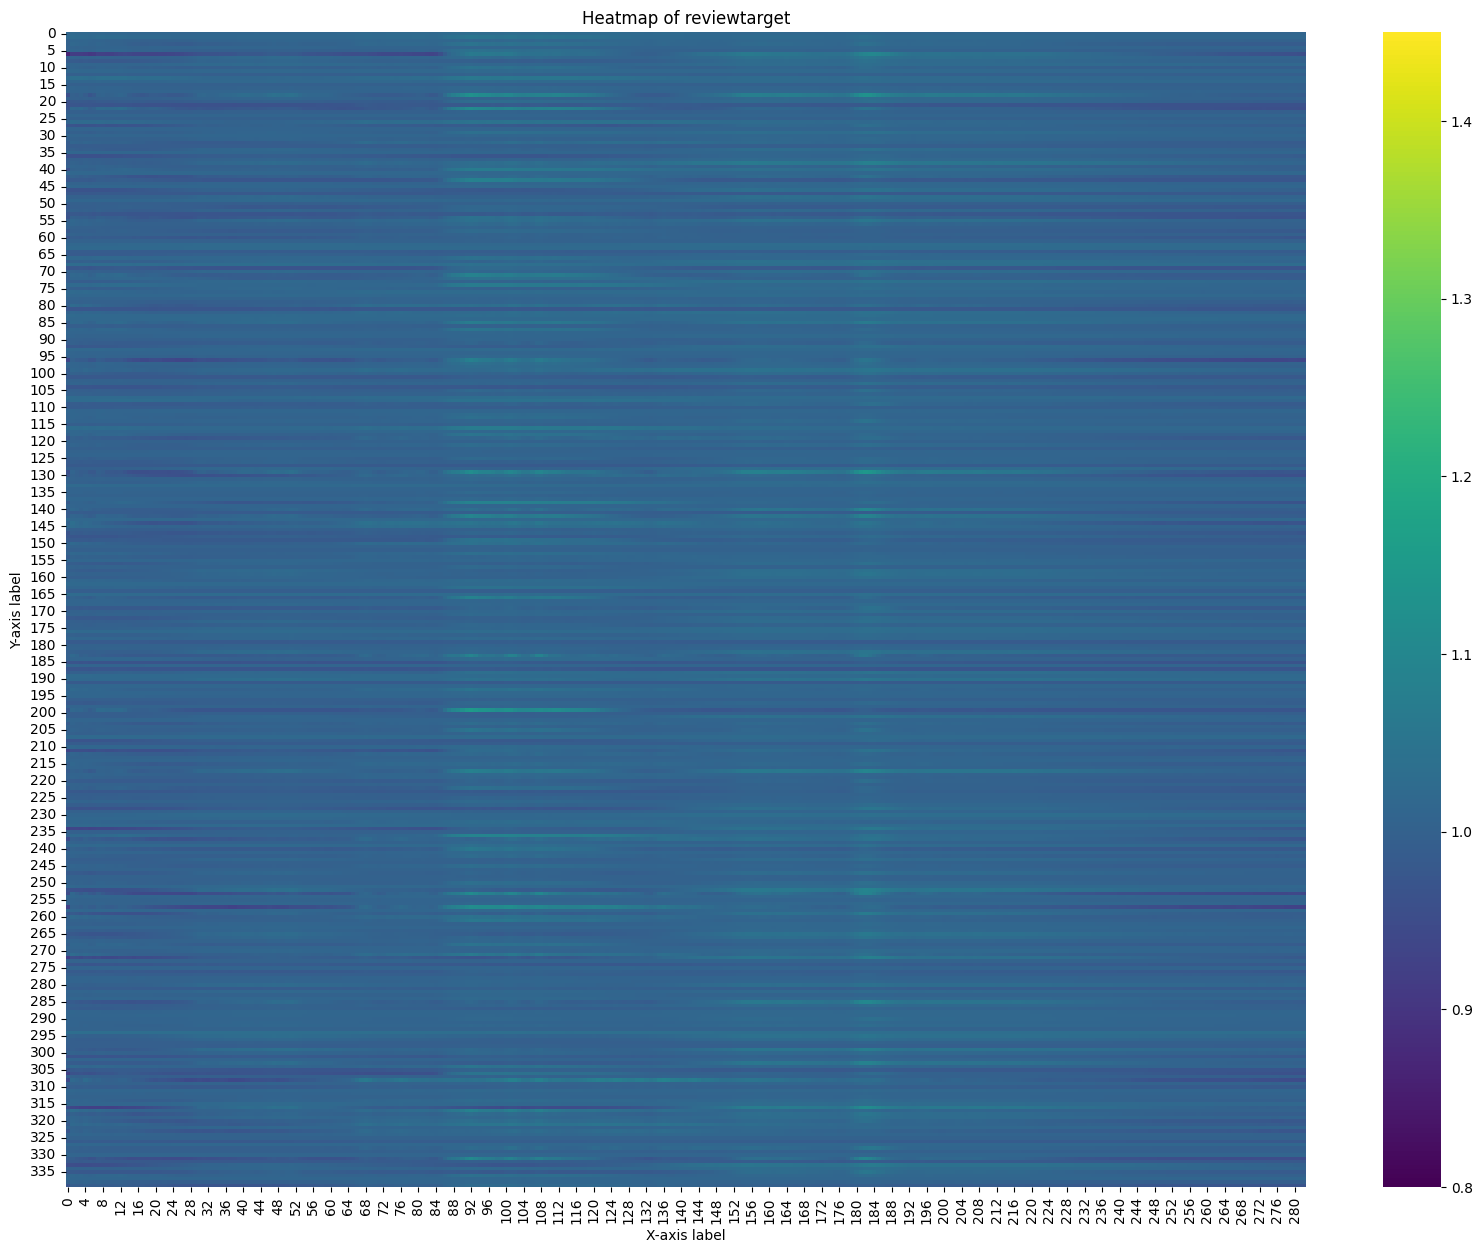

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(reviewtarget,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of reviewtarget")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [54]:
reviewtarget = reviewtarget.numpy()
reviewtarget.min(), reviewtarget.max()

(0.8628884, 1.1572386)

In [55]:
all_predictions = all_predictions * whitelight_s_test[:, np.newaxis]
newsigma = sigma_predictions * whitelight_s_test[:, np.newaxis]

In [56]:
reviewtarget = reviewtarget * whitelight_s_test[:, np.newaxis]

In [57]:
print(f"# R2 score: {r2_score(reviewtarget, all_predictions):.6f}")
sigma_pred = mean_squared_error(reviewtarget, all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.999506
# Root mean squared error: 0.000038


In [58]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        train_adc_info[mask].index,
                        sigma_pred=newsigma)

In [ ]:
# sub_df = postprocessing(all_predictions,
#                         wavelengths,
#                         train_adc_info[mask].index,
#                         sigma_pred=np.tile(
#                             np.where(train_adc_info[mask][['star']] <= 1,
#                                      0.000046, 0.000046), (1, 283)))

In [59]:
gll_score = competition_score(train_labels[mask].copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.6}")

# Estimated competition score: 0.654441


In [60]:
import numpy as np
from scipy import stats
from collections import Counter, defaultdict

# 假设 predict_targets 和 targets 是 numpy 数组
num_cols = all_predictions.shape[1]
threshold = 3
outlier_counts = Counter()
normal_columns = defaultdict(list)

for col in range(num_cols):
    errors = np.abs(all_predictions[:, col] - reviewtarget[:, col])
    outliers = np.where(errors > newsigma[:, col] * threshold)[0]
    normals = np.where(errors <= newsigma[:, col] * threshold)[0]

    # 统计每个异常点的频次
    outlier_counts.update(outliers)

    # 记录每个数据点在哪些列中是正常的
    for normal in normals:
        normal_columns[normal].append(col)

# 按频次排序
sorted_outliers = outlier_counts.most_common()

# 打印每个异常点的频次及其正常的列
for outlier, count in sorted_outliers:
    normal_cols = normal_columns[outlier]
    print(
        f"Data point {outlier} is an outlier in {count} columns and normal in columns: {normal_cols}"
    )

Data point 108 is an outlier in 282 columns and normal in columns: [269]
Data point 237 is an outlier in 121 columns and normal in columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 37, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 151, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282]
Data point 232 is an outlier in 109 columns and normal in columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,

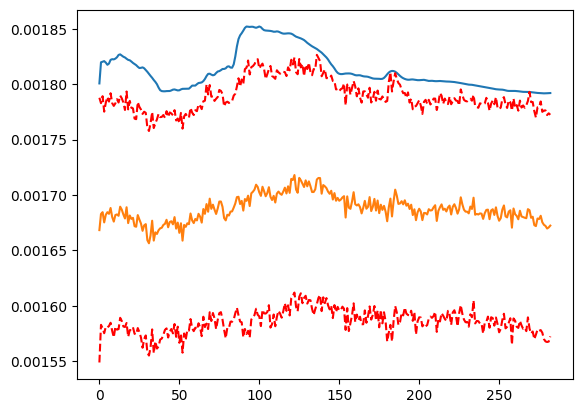

In [63]:
planet = 108
plt.plot(reviewtarget[planet, :])
plt.plot(all_predictions[planet, :])
plt.plot(all_predictions[planet, :] + 3 * newsigma[planet, :], 'r--')
plt.plot(all_predictions[planet, :] - 3 * newsigma[planet, :], 'r--')